In [ ]:
# Install required libraries

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00


In [ ]:
pip install transformers

In [ ]:
 pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import necessary libraries
import re # Regular expressions for text cleaning
import string # String operations
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
import torch# PyTorch for deep learning

# Scikit-learn utilities for text processing and classification
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF for feature extraction
from sklearn.svm import SVC # Support Vector Machine classifier
from sklearn.pipeline import make_pipeline # Pipeline for model building
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Model evaluation metrics
from sklearn.model_selection import train_test_split # Splitting data into training and testing sets

# Visualization tools
import seaborn as sns # For confusion matrix heatmaps
import matplotlib.pyplot as plt # For plotting graphs

# Hugging Face Transformers utilities for deep learning models
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Joblib for model persistence (saving and loading models)
import joblib
# The above libraries will help in implementing both traditional ML (SVM) and deep learning (BERT) approaches
# for toxic text classification.

In [ ]:
# Load the training and test dataset
train_df = pd.read_json("z639_assignment1_training.json", lines=True)
test_df = pd.read_json("z639_assignment1_test.json", lines=True)


In [ ]:
# Function to extract labels from composite_toxic using majority voting

'''
    Determines the label based on a majority vote from annotators.

    Parameters:
        annotations (list of tuples): Each tuple contains (label, confidence).

    Returns:
        bool: True if the majority votes toxic, False otherwise.
'''
def get_label(annotations):
    labels = [label for label, _ in annotations] # Extract only the labels
    return sum(labels) > len(labels) / 2  # True if more than half label it as toxic


# Apply the labeling function to the training dataset
train_df["label"] = train_df["composite_toxic"].apply(get_label)


# Text preprocessing function for SVM model
  """
  Cleans and standardizes text for model input.

    Steps:
    - Convert text to lowercase
    - Remove URLs
    - Remove mentions (@usernames) and hashtags (#hashtags)
    - Remove punctuation
    - Normalize extra spaces

    Parameters:
        text (str): Raw input text

    Returns:
        str: Cleaned text
    """

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

In [ ]:
# Convert text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
"""
- stop_words='english': Removes common words (e.g., "the", "and") that don’t add value.
- max_features=5000: Limits vocabulary size to the 5000 most important words.
"""
# Fit the TF-IDF vectorizer on the training text data and transform it into feature vectors
X = vectorizer.fit_transform(train_df['text'])
y = train_df['label'].values # Extract target labels

# Split dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM (Support Vector Machine) classifier with a linear kernel
svm_model = SVC(kernel='linear', probability=True)
"""
- kernel='linear': Uses a linear decision boundary for classification.
- probability=True: Enables probability estimates for predictions.
"""
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# SVM Predictions
y_pred_svm = svm_model.predict(X_val)
print("SVM Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm))

SVM Model Performance:
Accuracy: 0.74625
              precision    recall  f1-score   support

       False       0.77      0.94      0.84       590
        True       0.54      0.21      0.30       210

    accuracy                           0.75       800
   macro avg       0.66      0.57      0.57       800
weighted avg       0.71      0.75      0.70       800



In [ ]:
"""
Interpretation of Results:
- Accuracy: 74.6% (Shows overall correctness of the model).
- Precision: Measures the proportion of correctly identified toxic/non-toxic comments.
- Recall: Indicates how well the model detects toxic comments.
- F1-score: Harmonic mean of precision and recall (balances both metrics).
- Class Imbalance Issue:
  - Non-toxic (False) class has high precision and recall.
 -The low recall (0.21) for toxic comments in the SVM model is primarily due to dataset imbalance,
 lack of context in TF-IDF, short toxic comments, and the limitations of a linear decision boundary.
  Addressing these issues through better feature engineering and class balancing could significantly improve recall.
"""

In [ ]:
import pandas as pd

# Get 10 random samples from validation set
sample_indices = np.random.choice(len(y_val), 10, replace=False)

# Create a DataFrame to display predictions
svm_predictions_df = pd.DataFrame({
    "Text": train_df.iloc[sample_indices]['text'].values,  # # Extract original text from dataset
    "True Label": y_val[sample_indices],  # Actual label
    "Predicted Label": y_pred_svm[sample_indices]  # # Model's predicted labels
})

# Display the prediction table
print(svm_predictions_df)


                                                Text  True Label  \
0  is because small and same mess from place who ...       False   
1  i talk a lot read too much but yea see paragra...       False   
2  i very much hope the russians take really good...        True   
3                                   fuck you youtube        True   
4  is there a sign out front that says dead russi...        True   
5  thanks for sharing thats the first time ive re...        True   
6  ukrainians are still being killed this is beca...       False   
7  chrissy is a liar you leftists are hypocrites ...       False   
8                              youre a complete joke       False   
9  it took a protest by world champions to only r...       False   

   Predicted Label  
0             True  
1            False  
2            False  
3             True  
4            False  
5            False  
6            False  
7            False  
8             True  
9            False  


In [ ]:
# Load the pretrained BERT tokenizer (uncased version)
# "bert-base-uncased" is a standard version of BERT that converts all text to lowercase
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# The tokenizer converts raw text into tokenized input suitable for BERT
# It will split words into subwords, handle special tokens like [CLS] and [SEP],
# and generate token IDs for model input

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset # Hugging Face dataset utility
from sklearn.model_selection import train_test_split

# Convert text data into lists
texts = train_df["text"].tolist()
labels = train_df["label"].tolist()

# Split into train and validation sets (same as SVM)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert the split data into Hugging Face Dataset format for BERT
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})


In [ ]:
# Define a function to tokenize input text using the BERT tokenizer
"""
    Tokenizes input text for BERT model.

    Parameters:
        examples (dict): A dictionary containing text data.

    Returns:
        dict: Tokenized text with padding and truncation applied.
    """

def tokenize_function(examples):
    return tokenizer(examples["text"],  # Extract text from dataset
                     padding="max_length",#Ensures all sequences have the same length
                     truncation=True, # Truncates longer texts to fit within model constraints
                     max_length=512 # Maximum token length for BERT input
                     )

# Apply tokenization to the training and validation dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

"""
Explanation:
- Tokenization converts raw text into numerical token IDs for model input.
- Padding ensures all inputs are of uniform length (512 tokens).
- Truncation prevents long inputs from exceeding BERT's limit.
- The `map()` function applies the tokenization efficiently to the dataset.
"""

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:


# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

"""
Explanation:
- `bert-base-uncased`: A pre-trained BERT model that converts all text to lowercase.
- `num_labels=2`: Configures the model for binary classification (0 = non-toxic, 1 = toxic).
- The model is fine-tuned on our dataset to adapt to toxicity detection.
"""

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import necessary libraries from Hugging Face and Scikit-learn
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
)

"""
Explanation:
- `evaluation_strategy="epoch"`: Evaluates the model at the end of each epoch.
- `save_strategy="epoch"`: Saves model checkpoints after every epoch.
- `num_train_epochs=3`: The model will train for 3 complete iterations over the dataset.
- `warmup_steps=100`: Helps stabilize learning rate in the initial training phase.
- `weight_decay=0.01`: Regularization technique to reduce overfitting.
- `save_total_limit=2`: Keeps only the last 2 model checkpoints to save disk space.
- `load_best_model_at_end=True`: Ensures the best-performing model is used for evaluation.

This configuration ensures a structured and efficient training process.
"""



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

# Train the BERT model
trainer.train()

"""
Explanation:
- `Trainer` is a high-level API from Hugging Face that simplifies model training.
- `model`: The pre-trained BERT model we fine-tune on the dataset.
- `args`: Contains training configurations such as batch size, epochs, and learning rate.
- `train_dataset`: The tokenized training dataset formatted for input into the model.
- `eval_dataset`: The tokenized validation dataset for evaluation during training.
- `trainer.train()`: Initiates the fine-tuning process, optimizing the model to classify toxic comments.

This setup ensures that the model efficiently learns from labeled data while being evaluated at each epoch.
"""

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nandinireddykanchi (nandinireddykanchi-indiana-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.460846
2,0.491500,0.516181
3,0.262300,0.901521


TrainOutput(global_step=1200, training_loss=0.3422716204325358, metrics={'train_runtime': 1059.5859, 'train_samples_per_second': 9.06, 'train_steps_per_second': 1.133, 'total_flos': 2525866131456000.0, 'train_loss': 0.3422716204325358, 'epoch': 3.0})

In [ ]:
# Function to get predictions from BERT in batches
def get_predictions(model, tokenizer, texts, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)

    return predictions # Return the final list of predictions


# Generate predictions safely
predicted_labels_bert = get_predictions(model, tokenizer, test_df["text"].tolist(), batch_size=16)

# Convert predictions to True/False format
predicted_labels_bert = [bool(label) for label in predicted_labels_bert]

# Save predictions to CSV
submission_df = pd.DataFrame({
    "platform_id": test_df["platform_id"],
    "prediction": predicted_labels_bert
})

submission_filename = "nandini-assignment1-predictionfinal.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"BERT predictions saved to: {submission_filename}")
"""
    Generates predictions from the fine-tuned BERT model in batches.

    Parameters:
        model (transformers.PreTrainedModel): The trained BERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for BERT.
        texts (list of str): List of text inputs for prediction.
        batch_size (int, optional): Number of samples per batch (default is 16).

    Returns:
        list: Predicted labels (0 for non-toxic, 1 for toxic).
    """


BERT predictions saved to: nandini-assignment1-predictionfinal.csv


Validation Accuracy: 0.7837
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.89      0.86       590
        True       0.61      0.48      0.54       210

    accuracy                           0.78       800
   macro avg       0.72      0.68      0.70       800
weighted avg       0.77      0.78      0.77       800



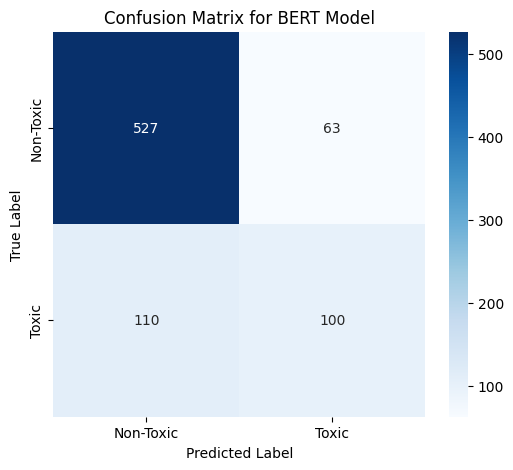

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on validation set
val_predictions = get_predictions(model, tokenizer, val_texts)  # Use validation texts
val_labels = val_labels  # Ensure these are correctly extracted

# Compute accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:\n", classification_report(val_labels, val_predictions))

# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for BERT Model")
plt.show()


In [ ]:
"""
Interpretation of Classification Report:
- Precision: Measures how many predicted toxic comments were actually toxic.
- Recall: Measures how many actual toxic comments were correctly predicted.
- F1-score: Harmonic mean of precision and recall, balancing both metrics.
- Support: Number of true occurrences of each class in the dataset.
"""